# IMPORTS

## Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Data

In [24]:
from novelty_detection.data import load_data
df = load_data("mgdata.txt", header_names=['t', 'x'])
print(df.shape)
df.head()

(1201, 2)


,t,x
0,0,1.200000
1,1,1.085805
2,2,0.982477
3,3,0.888982
4,4,0.804384


# PREPROCESSING

In [25]:
start, end = 118, 1118

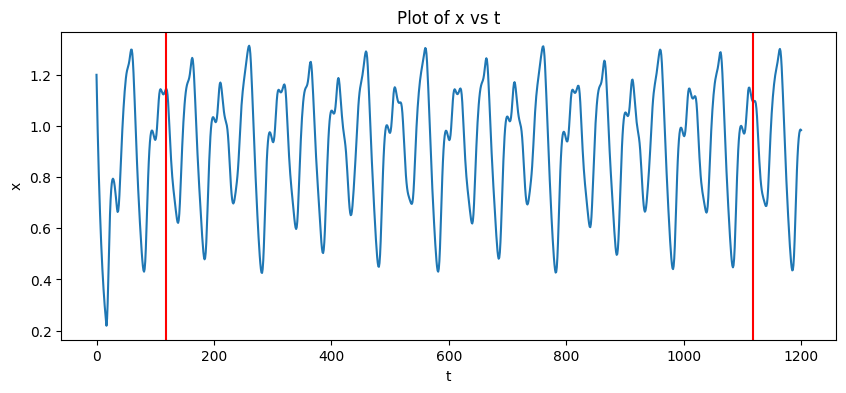

In [26]:
plt.figure(figsize=(10, 4))  # Wider figure size
plt.plot(df['t'], df['x'])
plt.axvline(x=start, color='red')
plt.axvline(x=end,color='red')
plt.title("Plot of x vs t")
plt.xlabel("t")
plt.ylabel("x")
plt.show()

In [27]:
list_of_dicts = []

# Iterate over the specified range of 't'
for t in range(start, end):
    # Extract 'x' values at specified offsets and store them in a dictionary
    dict_row = {
        't':t,
        'x(t-18)': df.loc[df['t'] == t - 18, 'x'].values[0],
        'x(t-12)': df.loc[df['t'] == t - 12, 'x'].values[0],
        'x(t-6)': df.loc[df['t'] == t - 6, 'x'].values[0],
        'x(t)': df.loc[df['t'] == t, 'x'].values[0],
        'x(t+6)': df.loc[df['t'] == t + 6, 'x'].values[0]
    }
    # Append the dictionary to the list
    list_of_dicts.append(dict_row)

# Convert the list of dictionaries to a DataFrame
data = pd.DataFrame(list_of_dicts, columns=list(list_of_dicts[0].keys()))

print(data.shape)
data.head()  # Displaying the first few rows of the new DataFrame for reference

(1000, 6)


,t,x(t-18),x(t-12),x(t-6),x(t),x(t+6)
0,118,0.945426,1.100331,1.129145,1.143128,1.004313
1,119,0.949830,1.125689,1.124705,1.144988,0.956414
2,120,0.964947,1.139706,1.123387,1.139072,0.910743
3,121,0.991405,1.143858,1.125572,1.121762,0.869387
4,122,1.026797,1.141285,1.130703,1.091658,0.833268


More general way to generate dataset

In [97]:
# Generate dataset
D = 4  # number of regressors == dim input data 
T = 6  # delay

# total of data points
N = end-start

list_of_lists = []

for t in range(start, end):
    X_row = [t]
    for d in reversed(range(1,D+1)):
        X_row.append(df.loc[df['t'] == t - (d - 1) * T, 'x'].values[0])
    # add target at the end of the list
    X_row.append(df.loc[df['t'] == t + T, 'x'].values[0])
    list_of_lists.append(X_row)

column_names = ['t']
for d in reversed(range(1,D+1)):
    col_name = f'x(t-{(d - 1) * T})'
    column_names.append(col_name)

column_names.append(f'x(t+{T})')

# Convert to DataFrame with specified column names
data2 = pd.DataFrame(list_of_lists, columns=column_names)
data2.head()  

,t,x(t-18),x(t-12),x(t-6),x(t-0),x(t+6)
0,118,0.945426,1.100331,1.129145,1.143128,1.004313
1,119,0.949830,1.125689,1.124705,1.144988,0.956414
2,120,0.964947,1.139706,1.123387,1.139072,0.910743
3,121,0.991405,1.143858,1.125572,1.121762,0.869387
4,122,1.026797,1.141285,1.130703,1.091658,0.833268


## Split

In [105]:
thresh = 500

In [106]:
features = ['x(t-18)', 'x(t-12)', 'x(t-6)', 'x(t)']
targets = ['x(t+6)']
time = ['t']

trnData = data.loc[:thresh-1, features]
chkData = data.loc[thresh:, features]

trnLbls = data.loc[:thresh-1, targets]
chkLbls = data.loc[thresh:, targets]

trnTime = data.loc[:thresh-1, time]
chkTime = data.loc[thresh:, time]

print('training data shape: ', trnData.shape)
print('validation data shape: ', chkData.shape)

training data shape:  (500, 4)
validation data shape:  (500, 4)


# TRAINING using tensorflow implementation

In [120]:
from novelty_detection.anfis_tf import ANFIS

# Example of use
fis = ANFIS(n_inputs=4, n_rules=16, learning_rate=5e-4)
fis.compile(run_eagerly=True)

# For training
fis.fit(trnData, trnLbls, epochs=250)

# For evaluation
val_loss = fis.evaluate(chkData, chkLbls)
print("Validation loss:", val_loss)

Epoch 1/250
10/16 [=================>............] - ETA: 0s - loss: 0.0768

c:\Users\ioliv\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
c:\Users\ioliv\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 [==============================] - 0s 15ms/step - loss: 0.0715
Epoch 2/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0536
Epoch 3/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0400
Epoch 4/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0297
Epoch 5/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0247
Epoch 6/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 7/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0159
Epoch 8/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0123
Epoch 9/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0095
Epoch 10/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0078
Epoch 11/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0058
Epoch 12/250
16/16 [==============================] - 0s 17ms/step - loss: 0.0045
Epoch 13/250
16/16 [=================

c:\Users\ioliv\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 [==============================] - 0s 2ms/step


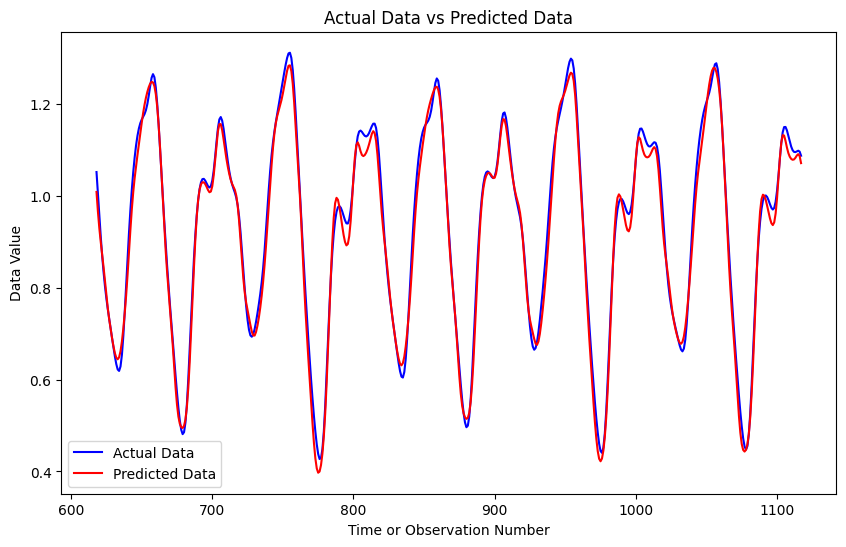

In [121]:
# Assuming fis is your ANFIS model and mg_series is your actual data
# Prepare your input data in the correct format (modify as necessary)

input_data = chkData.to_numpy() 

# Generate predictions
predicted_data = fis.predict(input_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkTime, chkLbls, label='Actual Data', color='blue')
plt.plot(chkTime, predicted_data, label='Predicted Data', color='red')
plt.title('Actual Data vs Predicted Data')
plt.xlabel('Time or Observation Number')
plt.ylabel('Data Value')
plt.legend()
plt.show()

16/16 [==============================] - 0s 3ms/step


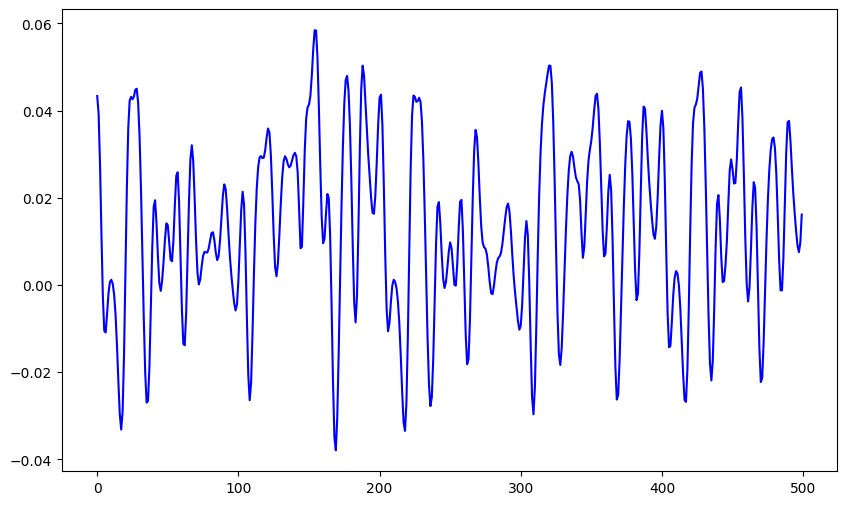

In [122]:
# Assuming fis is your ANFIS model and mg_series is your actual data
# Prepare your input data in the correct format (modify as necessary)
input_data = chkData.to_numpy() # Replace with your input data format

# Generate predictions
predicted_data = fis.predict(input_data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chkLbls.to_numpy().flatten()-predicted_data, label='Actual Data', color='blue')
plt.show()


# TRAINING using python implementation